## A tutorial to visually compare zero-shot and one-shot learning results

### Approach
- Directly generate a DOT file from one-shot learning example completed in previous tutorial
- Load the image containing zero-shot graph
- Visually compare the difference 

### Step 1: Download libraries
- Make use you download necessary library and files. 
- All downloaded and saved files can be located in the `content` folder if using google Colab

In [39]:
# uncomment the commands to download libraries and files
#!pip install python-dotenv
#!pip install dspy-ai == 2.4.17
#!pip install graphviz

import dspy
import os
import openai
import json
from dotenv import load_dotenv
from graphviz import Source
from IPython.display import display

### Step 2: Config DSPy with openAI 
- You `MUST` have an openAI api key
- load an openAI api key from `openai_api_key.txt` file
- or, hard code your open api key

In [40]:
def set_dspy():
    # ==============set openAI enviroment=========
    # Path to your API key file
    key_file_path = "openai_api_key.txt"

    # Load the API key from the file
    with open(key_file_path, "r") as file:
        openai_api_key = file.read().strip()

    # Set the API key as an environment variable
    os.environ["OPENAI_API_KEY"] = openai_api_key
    openai.api_key = os.environ["OPENAI_API_KEY"]
    turbo = dspy.OpenAI(model="gpt-3.5-turbo", max_tokens=2000, temperature=0.5)
    dspy.settings.configure(lm=turbo)
    return turbo
    # ==============end of set openAI enviroment=========


def set_dspy_hardcode_openai_key():
    os.environ["OPENAI_API_KEY"] = "sk-proj-yourapikeyhere"
    openai.api_key = os.environ["OPENAI_API_KEY"]
    turbo = dspy.OpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=2000)
    dspy.settings.configure(lm=turbo)
    return turbo


# provide `openai_api_key.txt` with your openAI api key
turbo = set_dspy()
# optionally, hard code your openAI api key at line 21
# turbo=set_dspy_hardcode_openai_key()

### Step 3: Load the cyber incident repot (e.g., conversation)

- the same conversation as previous tutorial

In [41]:
def load_text_file(file_path):
    """
    Load a text file and return its contents as a string.

    Parameters:
    file_path (str): The path to the text file.

    Returns:
    str: The contents of the text file.
    """
    try:
        with open(file_path, "r") as file:
            contents = file.read()
        return contents
    except FileNotFoundError:
        return "File not found."
    except Exception as e:
        return f"An error occurred: {e}"

conversation = load_text_file("04_output_for_viz.json")
print(conversation)

[
    {
        "type": "identity",
        "id": "identity--1cba2e3c-4bdb-4d0b-a87b-2d504ad5923f",
        "name": "OurCompany",
        "identity_class": "organization",
        "sectors": [
            "technology"
        ],
        "contact_information": "info@ourcompany.com"
    },
    {
        "type": "email-addr",
        "id": "email-addr--0c0d2094-df97-45a7-9e9c-223569a9e798",
        "value": "hr-dept@ourcompany-security.com"
    },
    {
        "type": "email-message",
        "id": "email-message--c79b6bde-4f4c-4b38-a8c8-fb82921d6b97",
        "is_multipart": false,
        "subject": "Urgent Benefits Package Update",
        "from_ref": "email-addr--0c0d2094-df97-45a7-9e9c-223569a9e798",
        "body": "Please click the link to review the changes to your benefits package."
    },
    {
        "type": "url",
        "id": "url--4c3b-4c4b-bb6c-ded6b2a4a567",
        "value": "http://phishing-link.com/login"
    },
    {
        "type": "user-account",
        "id": "use

### Step 4: Tell an LLM `WHAT` are the inputs/outputs by defining `dspy.Signature`

In [42]:
class DotGenerator(dspy.Signature):
    """Generate a evidence knowledge graph based on a cyber incident expressed in Structured Threat Information Expression (STIX)."""

    question: str = dspy.InputField(
        desc="a cyber incident expressed in Structured Threat Information Expression with JSON format."
    )

    answer: str = dspy.OutputField(
        desc="a graph in a dot format. The nodes of the graph are evidence entities and the edges of the graph are the relationships between evidence entities in STIX. A dot format is primarily associated with Graphviz, a graph visualization software. For example, a dot should looks like: digraph incident_name {...}. Don't include `````` "
    )

### Step 5: Tell an LLM `HOW` to generate answer. The business logic is defined in the module `.dspy.Predict`

In [43]:
# Important: Predict is better than ChainOfThough
def generate_answer_CoT(signature, text, output_file):
    generate_answer = dspy.Predict(signature)
    answer = generate_answer(question=text).answer  # here we use the module

    with open(output_file, "w") as dot_file:
        print(answer)
        dot_file.write(answer)
        return answer
    print(f"The evidence has been saved to the file {output_file}")

### Step 6: Actually call LLM to generate the graph in a `.DOT` file

In [44]:
output_file = "05_output.dot"
dot_description = generate_answer_CoT(
    DotGenerator,
    conversation,
    output_file,
)

digraph phishing_attack {
    "identity--1cba2e3c-4bdb-4d0b-a87b-2d504ad5923f" [label="OurCompany", shape="ellipse"];
    "email-addr--0c0d2094-df97-45a7-9e9c-223569a9e798" [label="hr-dept@ourcompany-security.com", shape="ellipse"];
    "email-message--c79b6bde-4f4c-4b38-a8c8-fb82921d6b97" [label="Urgent Benefits Package Update", shape="box"];
    "url--4c3b-4c4b-bb6c-ded6b2a4a567" [label="http://phishing-link.com/login", shape="ellipse"];
    "user-account--bd5631cf-2af6-4bba-bc92-37c60d020400" [label="Taylor (taylor@ourcompany.com)", shape="ellipse"];
    
    "observable--001" [label="hr-dept@ourcompany-security.com", shape="ellipse"];
    "observable--002" [label="http://phishing-link.com/login", shape="ellipse"];
    
    "indicator--1cba2e3c-4bdb-4d0b-a87b-2d504ad5923f" [label="Phishing Email Indicator", shape="diamond"];
    
    "incident--7a2b252e-c3e5-4bc2-bc6f-cb917ecf7857" [label="Phishing Attack on OurCompany", shape="box"];
    
    "relationship--3f1a8d8b-6a6e-4b5d-8e15-

### Step 7: Visualize one-shot learning results from a `.DOT` file

Graph saved as: 05_output_stix_oneshot.png


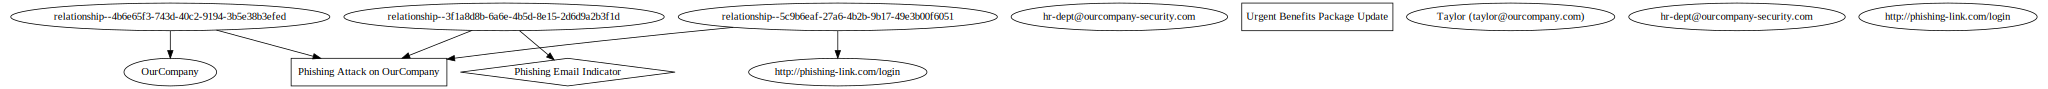

In [45]:
# Load the .DOT file
dot_file_path = "05_output.dot"

with open(dot_file_path, "r") as file:
    dot_content = file.read()

# Create a Graphviz Source object and render it
dot = Source(dot_content)

# Render the graph and save it as a PNG file
output_file_path = "05_output_stix_oneshot"
dot.format = "png"
dot.render(output_file_path, cleanup=True)

# Display the saved PNG file path
print(f"Graph saved as: {output_file_path}.png")

# Display the graph in the Jupyter notebook
dot

### Step 8: Visualize zero-shot learning results from previous tutorial

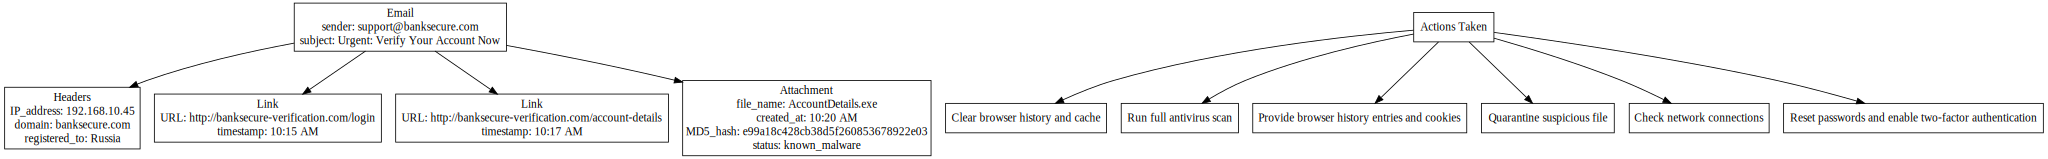

In [46]:
from IPython.display import SVG

# Path to the SVG file
image_path = "05_output_stix_zeroshot.svg"

# Display the SVG image
SVG(filename=image_path)

# Summary
- One-shot learning results make more sense when analyzing digital forensic evidence
- STIX mainly focus on cyber incident formalization, not forensic evidence
    - although basic evidence types are included in its document
- [Digital Forensic Knowledge Graph (DFKG)](https://github.com/frankwxu/digital-forensics-lab/tree/main/STIX_for_digital_forensics) is an extension of STIX
    - Cyber Forensic Domain Objects and Cyber Forensic Observable Objects